<a href="https://colab.research.google.com/github/RK22000/Rahuls-Another-Motion-Picture-Review-Classifier/blob/main/RAMPRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Rahul
# Run this cell to connect your google drive to this notebooks runtime directory.
# The connection only lasts for your specific session so the cell will need to be run once at the start of every session
# It also means that we cant actually access each others google drive through the notebook
# To ensure that directory stuff works well lets agree to this directory structure within our google drives
# MyDrive is the root directory in google drive. From there 
# MyDrive/CS_156/assignment_2b1
# assignment_2b1 is the directory where we will have our data files and stuff stored or both of our google drives

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Edward

import os
import re

def read_paths_for_classifier():
    pos_reviews_folder = input("Path for folder containing positive reviews: ")
    neg_reviews_folder = input("Path for folder containing negative reviews: ")
    return pos_reviews_folder, neg_reviews_folder

# Issue: https://rkan-sjsu.atlassian.net/browse/AMPRC-14
# Takes as input two folder paths
# Return value is a tuple of 2 arrays, each of which contains reviews(string)
def get_files_for_classifier(pos_reviews_folder, neg_reviews_folder):
    pos_reviews = []
    neg_reviews = []

    if pos_reviews_folder:
        for filename in os.listdir(pos_reviews_folder):
            pos_file = os.path.join(pos_reviews_folder, filename)
            if os.path.isfile(pos_file):
                my_file = open(pos_file, "r")
                pos_reviews.append(my_file.read())
                my_file.close()

    if neg_reviews_folder:
        for filename in os.listdir(neg_reviews_folder):
            pos_file = os.path.join(neg_reviews_folder, filename)
            if os.path.isfile(pos_file):
                my_file = open(pos_file, "r")
                neg_reviews.append(my_file.read())
                my_file.close()

    return (pos_reviews, neg_reviews)


# Parameter is string
# Return value is set of strings found in the review string
def preprocess(review):
    # lowercase everything
    review = review.lower()

    # remove numbers
    review = ''.join([char for char in review if not char.isdigit()])

    # remove contractions but also possessive words (Jack's, Tommy's)
    review = ' '.join([word for word in review.split() if "'" not in word])

    # remove special characters, keep words and spaces
    review = re.sub(r"[^a-z ]", "", review)

    review = [word for word in review.split()]
    return set(review)


# Issue: https://rkan-sjsu.atlassian.net/browse/AMPRC-16
# Parameters are arrays of strings
# Return value is tuple containing 2 lists, each of which contain sets of strings used in a review
def preprocess_all_reviews(pos_reviews, neg_reviews):
    for i in range(0, len(pos_reviews)):
        pos_reviews[i] = preprocess(pos_reviews[i])

    for i in range(0, len(neg_reviews)):
        neg_reviews[i] = preprocess(neg_reviews[i])

    return (pos_reviews, neg_reviews)
    

# Issue: https://rkan-sjsu.atlassian.net/browse/AMPRC-8
# Parameters are sets
# Return value is set
def get_all_words_used(pos_reviews, neg_reviews):
    all_evidence = set()
    for pos_set in pos_reviews:
        for word in pos_set:
            all_evidence.add(word)

    for neg_set in neg_reviews:
        for word in neg_set:
            all_evidence.add(word)

    return all_evidence





In [ ]:
# Rahul
import random
def extract_validation_data(data, ratio=0.1):
  """Extracts (and removes) validation data from the given data in the given ratio
  data: tuple with positive data as the first element and negative data as the second element
  returns: The validation tuple"""
  p_data, n_data = data
  p_valid = random.sample( p_data, int( ratio*len(p_data) ) )
  for item in p_valid:
    p_data.remove(item)
  n_valid = random.sample( n_data, int( ratio*len(n_data) ) )
  for item in n_valid:
    n_data.remove(item)
  return (p_valid, n_valid)

In [ ]:
# Rahul
import math

class DataSet:
    def __init__(self, pos_data, neg_data):
        self.pos_data = pos_data
        self.neg_data = neg_data

class DataSets:
    def __init__(self, pos_data, neg_data, tokenizer=lambda *args:set(), split_ratio=0.1, token_thresh=0.75, usefull_token_delta=0.01):
        self.valid_set = DataSet(*extract_validation_data( (pos_data, neg_data), ratio=split_ratio ) )
        self.train_set = DataSet(pos_data=pos_data, neg_data=neg_data)
        self.token_set = tokenizer(pos_data, neg_data)
        
        self.token_utility = { token: self.get_usefulness(token=token, delta=usefull_token_delta) for token in self.token_set }
        max_utility = max(self.token_utility, key=lambda z: self.token_utility[z])
        max_utility = self.token_utility[max_utility]
        self.top_tokens = [ token for token in self.token_set if self.token_utility[token] > token_thresh*max_utility ]
        self.top_tokens.sort(key=lambda token: self.token_utility[token], reverse=True)
    
    def get_usefulness(self, token, delta=0.01):
        if(not token in self.token_set): return 0
        pos_token_freq = len( [ review for review in self.train_set.pos_data if token in review ] )
        neg_token_freq = len( [ review for review in self.train_set.neg_data if token in review ] )
        # Observation the smaller I make delta the larger the largest usefullness value
        #print(f'toekn: {token} {pos_token_freq}/{neg_token_freq}')
        return abs(math.log2( (pos_token_freq+delta) / (neg_token_freq+delta) ))


    

        

In [ ]:
pos_path = r"/content/drive/MyDrive/CS_156/assignment_2b1/Movie Reviews/pos"
neg_path = r"/content/drive/MyDrive/CS_156/assignment_2b1/Movie Reviews/neg"
pos_reviews, neg_reviews = get_files_for_classifier(pos_path, neg_path)
pos_reviews, neg_reviews = preprocess_all_reviews(pos_reviews, neg_reviews)
data = DataSets(pos_data=pos_reviews,
                neg_data=neg_reviews,
                tokenizer=get_all_words_used,
                split_ratio=0.1,
                token_thresh=0.75)
train_set = data.train_set
valid_set = data.valid_set
token_set = data.token_set
top_tokens = data.top_tokens

print(f'''training positive reviews   = {len(train_set.pos_data)}
\t validation positive reviews = {len(valid_set.pos_data)}
training negative reviews   = {len(train_set.neg_data)}
\t validation negative reviews = {len(valid_set.neg_data)} ''')
#os.remove("allTokens.txt")
with open("allTokens.txt", "a") as file:
    for token in token_set:
        file.write(token + '\n')

print(f'''total tokens = {len(token_set)}
top tokens = {len(top_tokens)}''')

for i in range (10) :
    print(top_tokens[i] + " " + str(data.token_utility[top_tokens[i]]))
print(f'Last one {top_tokens[-1]} {data.token_utility[top_tokens[-1]]}')

training positive reviews   = 810
	 validation positive reviews = 90
training negative reviews   = 810
	 validation negative reviews = 90 
total tokens = 40242
top tokens = 1781
represent 10.345405246717796
symbol 10.345405246717796
degenerates 10.230020435705635
elliot 10.230020435705635
fashioned 10.230020435705635
ideals 10.10459875356437
mulan 10.10459875356437
melancholy 10.10459875356437
lovingly 10.10459875356437
slip 10.10459875356437
Last one biehn 8.233619676759702


In [ ]:
import heapq
from heapq import *

class Model:
    def __init__(self, token_set):
        """The model that will be trained with data. It will hold a token set as the set of posible evidences and it will know the conditional probabalities for each evidence token
        token_set: the set of significant tokens that the model should care about"""
        self.token_set = token_set
        self.cond_probabilities = {} # Map string to ( P(e|T), P(e|~T) )
    
    def is_pos_review(self, review, threshold=1.0):
        """Method to ask model to predict wheter the movie review is positive or negative"""
        score = 1
        for token in review:
            if token in self.token_set:
                post_pos, post_neg = self.cond_probabilities[token]
                score *= (post_pos/post_neg)
        return score>threshold
    
    def prob_pos_review(self, review):
        score = 1
        for token in review:
            if token in self.token_set:
                post_pos, post_neg = self.cond_probabilities[token]
                score *= (post_pos/post_neg)
        return score

    # https://rkan-sjsu.atlassian.net/browse/AMPRC-13
    def print_top_evidences(self, n=5):
        top_pos = heapq.nlargest( n=n, iterable=self.token_set, key=lambda token:self.cond_probabilities[token][0] )
        top_neg = heapq.nlargest( n=n, iterable=self.token_set, key=lambda token:self.cond_probabilities[token][1] )

        #for evidence in self.cond_probabilities:
            # Python heap's are minheaps by default, so we flip the sign of the values so that
            # larger numbers end up at the top of the heap
            # This assumes we want larger probabilties at the top of the heap
            #heappush(top_pos, (self.cond_probabilities[evidence][0], evidence))
            #heappush(top_neg, (self.cond_probabilities[evidence][1], evidence))

        print(f"Top {n} Positive Evidences:")
        for i in range(n):
            print(f"P{i+1}: {top_pos[i]} {self.cond_probabilities[top_pos[i]]}")

        print(f"Top {n} Negative Evidences:")
        for i in range(n):
            print(f"N{i+1}: {top_neg[i]} {self.cond_probabilities[top_neg[i]]}")
    
    
    # Issue: https://rkan-sjsu.atlassian.net/browse/AMPRC-12
    def store_model_as_file(self):
        # clears the file
        open("bayesian_model.txt", "w").close()

        my_file = open("bayesian_model.txt", "a")
        for evidence in self.cond_probabilities:
            my_file.write(f"{evidence}: {self.cond_probabilities[evidence][0]} present if positive review, "
                          f"{self.cond_probabilities[evidence][1]} present if negative review")
            my_file.write("\n")
        my_file.close()

class Trainer:
    """This class will train the model by setting the probabality values in the model"""
    def __init__(self, model, train_set):
        """model: the model to train
        train_set: DataSet object that contains the training data"""
        self.model = model
        self.train_set = train_set
    
    def token_cond_probs(self, token, delta=0.01):
        """Method to get the probabality of token being present in a reviews post positive review and post negative review
        token: the string evidence word
        delta: the smoothing constant added to the numerator and denominator in calculating the probabalitites
        returns: tuple of the post positive and post negative review"""
        prob_post_pos = (delta + len( [ review for review in self.train_set.pos_data if token in review ] ) )/ (delta + len( self.train_set.pos_data ) )
        prob_post_neg = (delta + len( [ review for review in self.train_set.neg_data if token in review ] ) )/ (delta + len( self.train_set.neg_data ) )
        return prob_post_pos, prob_post_neg
        

    def train(self, verbose=False):
        """Method to train the model
        verbose: print updates as the model is being trained"""
        indent = ""
        def verbate(msg):
            print(indent + msg)
        if verbose:
            verbate("Training Model")
            indent += "\t"
            verbate("Calculating post positive and post negative probabalities")
            indent += '\t'
        
        for token in self.model.token_set:
            self.model.cond_probabilities[token] = self.token_cond_probs(token)
            if verbose:
                verbate(f'Conditional probabalities for {token} = {self.model.cond_probabilities[token]}')
        
        if verbose:
            indent=""
            verbate("Done training")


In [ ]:
model = Model(data.top_tokens)
trainer = Trainer(model=model, train_set=data.train_set)
trainer.train(verbose=True)

Training Model
	Calculating post positive and post negative probabalities
		Conditional probabalities for represent = (0.01606153010456661, 1.2345526598437056e-05)
		Conditional probabalities for symbol = (0.01606153010456661, 1.2345526598437056e-05)
		Conditional probabalities for degenerates = (1.2345526598437056e-05, 0.014826977444722904)
		Conditional probabalities for elliot = (0.014826977444722904, 1.2345526598437056e-05)
		Conditional probabalities for fashioned = (0.014826977444722904, 1.2345526598437056e-05)
		Conditional probabalities for ideals = (0.013592424784879199, 1.2345526598437056e-05)
		Conditional probabalities for mulan = (0.013592424784879199, 1.2345526598437056e-05)
		Conditional probabalities for melancholy = (0.013592424784879199, 1.2345526598437056e-05)
		Conditional probabalities for lovingly = (0.013592424784879199, 1.2345526598437056e-05)
		Conditional probabalities for slip = (0.013592424784879199, 1.2345526598437056e-05)
		Conditional probabalities for th

In [ ]:
model.print_top_evidences()
model.store_model_as_file()

Top 5 Positive Evidences:
P1: represent (0.01606153010456661, 1.2345526598437056e-05)
P2: symbol (0.01606153010456661, 1.2345526598437056e-05)
P3: elliot (0.014826977444722904, 1.2345526598437056e-05)
P4: fashioned (0.014826977444722904, 1.2345526598437056e-05)
P5: ideals (0.013592424784879199, 1.2345526598437056e-05)
Top 5 Negative Evidences:
N1: degenerates (1.2345526598437056e-05, 0.014826977444722904)
N2: justin (1.2345526598437056e-05, 0.012357872125035493)
N3: wielding (1.2345526598437056e-05, 0.012357872125035493)
N4: feeble (1.2345526598437056e-05, 0.012357872125035493)
N5: setups (1.2345526598437056e-05, 0.011123319465191787)


In [ ]:
import matplotlib.pyplot as plt

class Tester:
    def __init__(self, model, valid_set):
        self.model = model
        self.valid_set = valid_set
    def test(self, threshold=1.0):
        true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
        for review in self.valid_set.pos_data:
            if self.model.is_pos_review(review, threshold): true_pos+=1
            else: false_neg+=1
        for review in self.valid_set.neg_data:
            if not self.model.is_pos_review(review=review, threshold=threshold): true_neg+=1
            else: false_pos+=1
        total_tests = true_pos + true_neg + false_pos + false_neg
        accuracy, tpr, fpr = (true_pos+true_neg)/total_tests, true_pos/(true_pos+true_neg), false_pos/(false_pos+false_neg)
        return accuracy, tpr, fpr
    
    def plot_thresholds(self, thresholds):
        results = [ self.test(threshold=thresh) for thresh in thresholds ]
        accus, tprs, fprs = zip(*results)
        plt.plot(thresholds, accus, "ro-", label="accuracy")
        plt.legend()
        #plt.plot(thresholds, t)
    

([<matplotlib.lines.Line2D at 0x7f359cd40dd0>], 9)

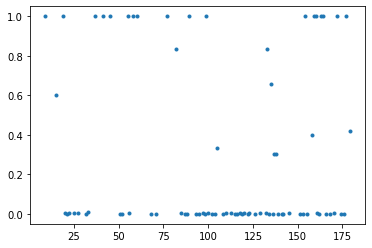

In [ ]:
x, y = [], []
for i, review in enumerate( data.valid_set.pos_data+data.valid_set.neg_data ):
    if model.prob_pos_review(review) > 1.1: continue
    x+=[i]
    y+=[model.prob_pos_review(review)]
plt.plot(x, y, "."), x[0]

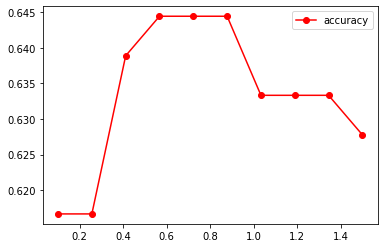

In [ ]:
import numpy as np
tester = Tester(model, data.valid_set)
tester.plot_thresholds(np.linspace(start=0.1, stop=1.5, num=10))

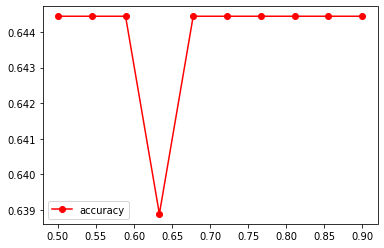

In [ ]:
tester.plot_thresholds(np.linspace(start=0.5, stop=0.9, num=10))

In [ ]:
tester.test(threshold=0.9)

(0.6444444444444445, 0.6293103448275862, 0.734375)

# Everything together
I also merged all the imports together at the top, corrected some spelling mistakes, commented the code I worked on, and put all code that ran in global space into a main function.

I also added documentation at the top describing the program in general. In main function, I have code to comment and uncomment depending on whether we're working in Google Drive or on local machine.

The professor didn't ask us to evaluate our model for this assignment I think, so I left that part off.

In [ ]:
"""
Rahul Kandekar, Edward Hoang
CS156
The purpose of this program is to build a movie review classifier that takes as input
two folders which contain movie reviews judged as positive and negative, respectively.
The movie reviews are then processed and converted into a form which can be used for
training a Bayesian classifier or evaluating it. The Bayesian model is then built and
stored as file. Finally, the top 5 positive and top 5 negative evidences are printed.
"""

import os
import re
import random
import math
import heapq


def read_paths_for_classifier():
    """
    This function reads from input the folder paths for positive and negative
    reviews.
    returns: a tuple containing the paths for positive reviews and negative reviews folders
    """
    pos_reviews_folder = input("Path for folder containing positive reviews: ")
    neg_reviews_folder = input("Path for folder containing negative reviews: ")
    return (pos_reviews_folder, neg_reviews_folder)


def get_files_for_classifier(pos_reviews_folder, neg_reviews_folder):
    """
    This function reads every file in the folder paths passed to it and stores the contents
    of each file as a string into either the pos_reviews array or the neg_reviews one.
    pos_reviews_folder: the folder path for the positive reviews.
    neg_reviews_folder: the folder path for the negative reviews.
    returns: a tuple of 2 arrays, each of which contains reviews, which are stored as strings.
    """
    pos_reviews = []
    neg_reviews = []

    if pos_reviews_folder:
        for filename in os.listdir(pos_reviews_folder):
            pos_file = os.path.join(pos_reviews_folder, filename)
            if os.path.isfile(pos_file):
                my_file = open(pos_file, "r")
                pos_reviews.append(my_file.read())
                my_file.close()

    if neg_reviews_folder:
        for filename in os.listdir(neg_reviews_folder):
            pos_file = os.path.join(neg_reviews_folder, filename)
            if os.path.isfile(pos_file):
                my_file = open(pos_file, "r")
                neg_reviews.append(my_file.read())
                my_file.close()

    return (pos_reviews, neg_reviews)


def preprocess(review):
    """
    This function preprocesses a review, turning all words into lowercase, removing
    all numbers, removing words containing apostrophes, and removing all special
    characters. Finally, it turns the string into a set of strings.
    review: a string containing the content of a review.
    returns: a set of the strings contained in the review after preprocessing.
    """
    review = review.lower()
    review = ''.join([char for char in review if not char.isdigit()])
    review = ' '.join([word for word in review.split() if "'" not in word])
    review = re.sub(r"[^a-z ]", "", review)
    review = [word for word in review.split()]
    return set(review)


def preprocess_all_reviews(pos_reviews, neg_reviews):
    """
    This function preprocesses all reviews, both positive and negative.
    pos_reviews: an array of strings, where each string is the content of a positive review text file.
    neg_reviews: an array of strings, where each string is the content of a negative review text file.
    returns: a tuple containing 2 arrays, each containing sets of strings used in a particular review.
    """
    for i in range(0, len(pos_reviews)):
        pos_reviews[i] = preprocess(pos_reviews[i])

    for i in range(0, len(neg_reviews)):
        neg_reviews[i] = preprocess(neg_reviews[i])

    return (pos_reviews, neg_reviews)


def get_all_words_used(pos_reviews, neg_reviews):
    """
    This function traverses through every word in every set of each array and adds
    the word to the all_evidence set. Then, it returns it.
    pos_reviews: a set containing the words used in a particular positive review.
    neg_reviews: a set containing the words used in a particular negative review.
    returns: a set containing every word used from all reviews.
    """
    all_evidence = set()
    for pos_set in pos_reviews:
        for word in pos_set:
            all_evidence.add(word)

    for neg_set in neg_reviews:
        for word in neg_set:
            all_evidence.add(word)

    return all_evidence


def extract_validation_data(data, ratio=0.1):
    """Extracts (and removes) validation data from the given data in the given ratio
  data: tuple with positive data as the first element and negative data as the second element
  returns: The validation tuple"""
    p_data, n_data = data
    p_valid = random.sample(p_data, int(ratio * len(p_data)))
    for item in p_valid:
        p_data.remove(item)
    n_valid = random.sample(n_data, int(ratio * len(n_data)))
    for item in n_valid:
        n_data.remove(item)
    return (p_valid, n_valid)


class DataSet:
    """Class to model a dataset containing positively and negatively labeled data"""
    def __init__(self, pos_data, neg_data):
        """pos_data: array of positive data
        neg_data: array of negative data"""
        self.pos_data = pos_data
        self.neg_data = neg_data


class DataSets:
    """Class to model datasets containing training and validation datasets"""
    def __init__(self, pos_data, neg_data, tokenizer=lambda *args: set(), split_ratio=0.1, token_thresh=0.75,
                 usefull_token_delta=0.01):
        """pos_data: array of positive data
        neg_data: array of negative data
        tokenizer: methods to generate tokens from pos_data and neg_data
        split_ratio: size of validation set compared to full dataset
        token_thresh: A utility value is calculated for each token. token_thresh indicates the minimun fraction of the top utility that a token must have to be considered as a usefull token
        usefull_token_delta: the fraction smoothing constant used in calculating the utility of tokens"""

        self.valid_set = DataSet(*extract_validation_data((pos_data, neg_data), ratio=split_ratio))
        self.train_set = DataSet(pos_data=pos_data, neg_data=neg_data)
        self.token_set = tokenizer(pos_data, neg_data)

        self.token_utility = {token: self.get_usefulness(token=token, delta=usefull_token_delta) for token in
                              self.token_set}
        max_utility = max(self.token_utility, key=lambda z: self.token_utility[z])
        max_utility = self.token_utility[max_utility]
        self.top_tokens = [token for token in self.token_set if self.token_utility[token] > token_thresh * max_utility]
        self.top_tokens.sort(key=lambda token: self.token_utility[token], reverse=True)

    def get_usefulness(self, token, delta=0.01):
        """Calculates the utility of a token
        token: token whoes utility to calculate
        delta: the smoothing constant"""
        if (not token in self.token_set): return 0
        pos_token_freq = len([review for review in self.train_set.pos_data if token in review])
        neg_token_freq = len([review for review in self.train_set.neg_data if token in review])
        # Observation the smaller I make delta the larger the largest usefullness value
        # print(f'toekn: {token} {pos_token_freq}/{neg_token_freq}')
        return abs(math.log2((pos_token_freq + delta) / (neg_token_freq + delta)))


class Model:
    def __init__(self, token_set):
        """The model that will be trained with data. It will hold a token set as the set of posible evidences and it will know the conditional probabalities for each evidence token
        token_set: the set of significant tokens that the model should care about"""
        self.token_set = token_set
        self.cond_probabilities = {}  # Map string to ( P(e|T), P(e|~T) )

    def is_pos_review(self, review, threshold=0.9):
        """Method to ask model to predict whether the movie review is positive or negative
        review: the review to judge
        threshold: minimum positive score required to be judged positive review"""
        return score_pos_review(review) > threshold

    def score_pos_review(self, review):
        """Method to ask model to predict whether the movie review is positive or negative
        review: the review to scored"""
        score = 1
        for token in review:
            if token in self.token_set:
                post_pos, post_neg = self.cond_probabilities[token]
                score *= (post_pos / post_neg)
        return score

    def print_top_evidences(self, n=5):
        """
        The method finds the top n positive and negative evidences and prints them.
        n: the number of top evidences being sought.
        """
        top_pos = heapq.nlargest(n=n, iterable=self.token_set, key=lambda token: self.cond_probabilities[token][0])
        top_neg = heapq.nlargest(n=n, iterable=self.token_set, key=lambda token: self.cond_probabilities[token][1])

        print(f"Top {n} Positive Evidences:")
        for i in range(n):
            print(f"P{i + 1}: {top_pos[i]} {self.cond_probabilities[top_pos[i]]}")

        print(f"Top {n} Negative Evidences:")
        for i in range(n):
            print(f"N{i + 1}: {top_neg[i]} {self.cond_probabilities[top_neg[i]]}")

    def store_model_as_file(self, pathname="bayesian_model.txt"):
        """
        This method clears the bayesian_model.txt file before writing to it the Bayesian model,
        which is a list of evidence and probability values.
        """
        open(pathname, "w").close()

        my_file = open(pathname, "a")
        for evidence in self.cond_probabilities:
            my_file.write(f"{evidence}: {self.cond_probabilities[evidence][0]} present if positive review, "
                          f"{self.cond_probabilities[evidence][1]} present if negative review")
            my_file.write("\n")
        my_file.close()


class Trainer:
    """This class will train the model by setting the probability values in the model"""

    def __init__(self, model, train_set):
        """model: the model to train
        train_set: DataSet object that contains the training data"""
        self.model = model
        self.train_set = train_set

    def token_cond_probs(self, token, delta=0.01):
        """Method to get the probability of token being present in a reviews post positive review and post negative review
        token: the string evidence word
        delta: the smoothing constant added to the numerator and denominator in calculating the probabilities
        returns: tuple of the post positive and post negative review"""
        prob_post_pos = (delta + len([review for review in self.train_set.pos_data if token in review])) / (
                delta + len(self.train_set.pos_data))
        prob_post_neg = (delta + len([review for review in self.train_set.neg_data if token in review])) / (
                delta + len(self.train_set.neg_data))
        return prob_post_pos, prob_post_neg

    def train(self, verbose=False):
        """Method to train the model
        verbose: print updates as the model is being trained"""
        indent = ""

        def verbate(msg):
            print(indent + msg)

        if verbose:
            verbate("Training Model")
            indent += "\t"
            verbate("Calculating post positive and post negative probabalities")
            indent += '\t'

        for token in self.model.token_set:
            self.model.cond_probabilities[token] = self.token_cond_probs(token)
            if verbose:
                verbate(f'Conditional probabalities for {token} = {self.model.cond_probabilities[token]}')

        if verbose:
            indent = ""
            verbate("Done training")


def main():
    """
    This function reads the paths of the folders containing positive and negative
    movie reviews. It then finds and prints the most useful evidence. From there,
    it builds the Bayesian model and produces the desired output.
    """
    # Used for Google Drive on colab
    pos_path = r"/content/drive/MyDrive/CS_156/assignment_2b1/Movie Reviews/pos"
    neg_path = r"/content/drive/MyDrive/CS_156/assignment_2b1/Movie Reviews/neg"

    # Used for local machine
    # pos_path, neg_path = read_paths_for_classifier()

    pos_reviews, neg_reviews = get_files_for_classifier(pos_path, neg_path)
    pos_reviews, neg_reviews = preprocess_all_reviews(pos_reviews, neg_reviews)
    data = DataSets(pos_data=pos_reviews,
                    neg_data=neg_reviews,
                    tokenizer=get_all_words_used,
                    split_ratio=0.1,
                    token_thresh=0.75)
    train_set = data.train_set
    valid_set = data.valid_set
    token_set = data.token_set
    top_tokens = data.top_tokens

    print(f'''training positive reviews   = {len(train_set.pos_data)}
    \t validation positive reviews = {len(valid_set.pos_data)}
    training negative reviews   = {len(train_set.neg_data)}
    \t validation negative reviews = {len(valid_set.neg_data)} ''')
    # os.remove("allTokens.txt")
    with open("allTokens.txt", "a") as file:
        for token in token_set:
            file.write(token + '\n')

    print(f'''total tokens = {len(token_set)}
    top tokens = {len(top_tokens)}''')

    for i in range(10):
        print(top_tokens[i] + " " + str(data.token_utility[top_tokens[i]]))
    print(f'Last one {top_tokens[-1]} {data.token_utility[top_tokens[-1]]}')

    model = Model(data.top_tokens)
    trainer = Trainer(model=model, train_set=data.train_set)
    trainer.train(verbose=False)

    model.print_top_evidences()
    model.store_model_as_file()


if __name__ == '__main__':
    """
    This is where the program runs.
    """
    main()



# Play ground
Play ground is where we play with stuff, figure stuff out. Then when we have figured it out we can comit it to the growing code above

In [ ]:
# Test the model
true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
for review in data.valid_set.pos_data:
    if model.is_pos_review(review): true_pos+=1
    else: false_neg+=1
for review in data.valid_set.neg_data:
    if not model.is_pos_review(review=review): true_neg+=1
    else: false_pos+=1
total_tests = true_pos + true_neg + false_pos + false_neg
print(f'accuracy={(true_pos+true_neg)/total_tests}, tpr={true_pos/(true_pos+true_neg)}, fpr={false_pos/(false_pos+false_neg)}')

accuracy=0.6333333333333333, tpr=0.5526315789473685, fpr=0.5909090909090909


In [ ]:
token = "biehn"
pos_token_freq = len( [ review for review in data.train_set.pos_data if token in review ] )
neg_token_freq = len( [ review for review in data.train_set.neg_data if token in review ] )
pos_token_freq, neg_token_freq

(3, 0)

In [ ]:
print(train_set.pos_data[735])

{'adapting', 'made', 'son', 'car', 'georgia', 'together', 'crashing', 'cinematic', 'widow', 'loving', 'element', 'patient', 'freeman', 'routine', 'delicate', 'cocoon', 'gentle', 'feels', 'scenes', 'incarnations', 'cancels', 'passenger', 'revolves', 'los', 'natural', 'under', 'ago', 'skin', 'put', 'ways', 'town', 'who', 'at', 'too', 'exceedingly', 'there', 'stamp', 'good', 'pair', 'life', 'boolie', 'feisty', 'such', 'banter', 'incorporates', 'to', 'human', 'seen', 'chicken', 'rewards', 'action', 'anything', 'stagey', 'mercies', 'now', 'slowly', 'norway', 'guilty', 'pizza', 'calling', 'king', 'treats', 'were', 'once', 'escorted', 'see', 'her', 'esther', 'wealth', 'into', 'color', 'surely', 'winning', 'adaptation', 'sweet', 'quiet', 'comedies', 'a', 'forbids', 'does', 'daisy', 'nature', 'flowers', 'rooms', 'especially', 'just', 'reluctant', 'civil', 'break', 'understands', 'reprising', 'aykroyd', 'initially', 'nevertheless', 'smidgen', 'slow', 'morgan', 'advent', 'my', 'than', 'might', 't

In [ ]:
from IPython.core.display import Math
# Rahul
# This section works with filtering the token set to keep only the usefull tokens

# lets work with a specific token

token = "awesome"
print (token in token_set)


# Dependence of 'good' and pos review
pos_token_freq = len( [ review for review in train_set.pos_data if token in review ] )
neg_token_freq = len( [ review for review in train_set.neg_data if token in review ] )

import math

math.log2( (pos_token_freq*1800) / ( (pos_token_freq+neg_token_freq) * 900 ) ) - math.log2( (neg_token_freq*1800) / ( (pos_token_freq+neg_token_freq) * 900 ) )

#pos_token_freq, neg_token_freq

True


0.7776075786635521

In [ ]:
import math
def get_usefulness(self, token, delta=0.01):
    if(not token in self.token_set): return 0
    pos_token_freq = len( [ review for review in self.train_set.pos_data if token in review ] )
    neg_token_freq = len( [ review for review in self.train_set.neg_data if token in review ] )
    # Observation the smaller I make delta the larger the largest usefullness value
    #print(f'toekn: {token} {pos_token_freq}/{neg_token_freq}')
    return abs(math.log2( (pos_token_freq+delta) / (neg_token_freq+delta) ))

DataSets.get_usefulness = get_usefulness

In [ ]:
tokens = [ (token, data.get_usefulness(token)) for token in data.token_set ]
tokens.sort(key=lambda z:z[1], reverse=True)
for i in range(10):
    print(tokens[i])

('avoids', 10.732167425663386)
('insipid', 10.55170826162069)
('wasting', 10.230020435705635)
('degenerates', 10.230020435705635)
('symbol', 10.230020435705635)
('melancholy', 10.10459875356437)
('lovingly', 10.10459875356437)
('justin', 10.10459875356437)
('thematic', 10.10459875356437)
('ideals', 9.967226258835993)


In [ ]:
threshold = 0.75*tokens[0][1]
top_tokens = [ token for token in tokens if token[1] > threshold]
len( top_tokens ), len(tokens), top_tokens[-1]

(1785, 40339, ('fur', 8.233619676759702))

In [ ]:
def get_top_tokens(self, threshold_frac=0.75, delta=0.01):
    